In [33]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPositionEmbeddings(torch.nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class TemporalEmbedding(torch.nn.Module):
    def __init__(self, dim_emb, dim_out):
        super().__init__()
        self.linear = torch.nn.Linear(dim_emb, dim_out)
        self.temb = SinusoidalPositionEmbeddings(dim_emb)

    def forward(self, x, time):
        temb = self.temb(time)
        emb = self.linear(temb)
        emb = emb[:, :, None, None]
        out = x + emb
        return out

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [34]:
### Tiny Version ###
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        base_channel = 16

        factor = 2 if bilinear else 1

        self.inc = (DoubleConv(n_channels, base_channel))
        self.down1 = (Down(base_channel, base_channel * 2))
        self.down2 = (Down(base_channel * 2, base_channel * 4 // factor))
        self.up1 = (Up(base_channel * 4, base_channel * 2 // factor, bilinear))
        self.up2 = (Up(base_channel * 2, base_channel, bilinear))
        self.outc = (OutConv(base_channel, n_classes))

        self.embed1 = TemporalEmbedding(1024, n_channels)
        self.embed2 = TemporalEmbedding(1024, base_channel)
        self.embed3 = TemporalEmbedding(1024, base_channel * 2)
        self.embed4 = TemporalEmbedding(1024, base_channel * 4)
        self.embed5 = TemporalEmbedding(1024, base_channel * 2)
        self.embed6 = TemporalEmbedding(1024, base_channel)

    def forward(self, x, t):
        x = self.embed1(x, t)
        x1 = self.inc(x)

        x1 = self.embed2(x1, t)
        x2 = self.down1(x1)

        x2 = self.embed3(x2, t)
        x3 = self.down2(x2)

        x3 = self.embed4(x3, t)
        x = self.up1(x3, x2)

        x = self.embed5(x, t)
        x = self.up2(x, x1)

        x = self.embed6(x, t)
        logits = self.outc(x)
        return logits


In [35]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        base_channel = 32
        factor = 2 if bilinear else 1

        self.inc = DoubleConv(n_channels, base_channel)
        self.down1 = Down(base_channel, base_channel * 2)
        self.down2 = Down(base_channel * 2, base_channel * 4)
        self.down3 = Down(base_channel * 4, base_channel * 8)
        self.down4 = Down(base_channel * 8, base_channel * 16 // factor)

        self.up1 = Up(base_channel * 16, base_channel * 8 // factor, bilinear)
        self.up2 = Up(base_channel * 8, base_channel * 4 // factor, bilinear)
        self.up3 = Up(base_channel * 4, base_channel * 2 // factor, bilinear)
        self.up4 = Up(base_channel * 2, base_channel, bilinear)

        self.outc = OutConv(base_channel, n_classes)

        self.embed1 = TemporalEmbedding(1024, 1)
        self.embed2 = TemporalEmbedding(1024, base_channel)
        self.embed3 = TemporalEmbedding(1024, base_channel * 2)
        self.embed4 = TemporalEmbedding(1024, base_channel * 4)
        self.embed5 = TemporalEmbedding(1024, base_channel * 8)
        self.embed6 = TemporalEmbedding(1024, base_channel * 16)
        self.embed7 = TemporalEmbedding(1024, base_channel * 8)
        self.embed8 = TemporalEmbedding(1024, base_channel * 4)
        self.embed9 = TemporalEmbedding(1024, base_channel * 2)
        self.embed10 = TemporalEmbedding(1024, base_channel)

    def forward(self, x, t):
        x = self.embed1(x, t)
        x1 = self.inc(x)

        x1 = self.embed2(x1, t)
        x2 = self.down1(x1)

        x2 = self.embed3(x2, t)
        x3 = self.down2(x2)

        x3 = self.embed4(x3, t)
        x4 = self.down3(x3)

        x4 = self.embed5(x4, t)
        x5 = self.down4(x4)

        x5 = self.embed6(x5, t)
        x = self.up1(x5, x4)

        x = self.embed7(x, t)
        x = self.up2(x, x3)

        x = self.embed8(x, t)
        x = self.up3(x, x2)

        x = self.embed9(x, t)
        x = self.up4(x, x1)

        x = self.embed10(x, t)
        logits = self.outc(x)
        return logits

In [36]:
from torch import Tensor
class DiffusionProcess:
    def __init__(self, device, batchSize, timeSteps):
        self.device = device
        self.batchSize = batchSize
        self.timeSteps = timeSteps

        self.betas = torch.sigmoid(torch.linspace(-6, 6, timeSteps)).to(device) * (0.02 - 0.0001) + 0.0001
        self.alphas = 1.0 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_1_m_alpha_bar = torch.sqrt(1 - self.alpha_bar)

    def forward(self, x_0, t, noise):
        img_pt_i = self.sqrt_alpha_bar[t].view((x_0.shape[0], 1, 1, 1)) * x_0
        noise_pt_i = self.sqrt_1_m_alpha_bar[t].view((x_0.shape[0], 1, 1, 1)) * noise
        x_i = img_pt_i + noise_pt_i
        return x_i

    def inverse(self, xt, et, t):
        xt = xt.to(self.device)
        et = et.to(self.device)
        epsilon_t = torch.randn_like(xt).to(self.device)
        noise_pt_tm1 = (self.betas[t] / self.sqrt_1_m_alpha_bar[t]) * et
        xt = (xt.to(self.device) - noise_pt_tm1.to(self.device)) / torch.sqrt(self.alphas[t]).to(self.device) + self.betas[t].sqrt() * epsilon_t.to(self.device)
        return xt

In [37]:
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST, FashionMNIST

batch_size = 100
to_tensor = torchvision.transforms.ToTensor()
normalize = torchvision.transforms.Normalize((0.1307,), (0.3081,))
transform = torchvision.transforms.Compose([to_tensor, normalize])

trainset = MNIST("./data/", train=True, download=True, transform=transform)
testset = MNIST("./data/", train=False, download=True, transform=transform)
#trainset = FashionMNIST(root="./data/", train=True, download=True, transform=transform)
#testset = FashionMNIST(root="./data/", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [38]:
import torch
from torch import optim
from tqdm import tqdm, trange

# Training new mode or reload trained model:
reloadModel = False
trainModel = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


if not reloadModel:
    model = UNet(1, 1).to(device)
else:
    model = UNet(1, 1).to(device)
    model.load_state_dict(torch.load("mnistGPU (150).pth"))
    # todo - "mnistGPU (150).pth" --> Pretrained MNIST Model
    # todo - "fmnistGPU (150).pth" --> Pretrained FMNIST Model
    
    #modelCPU = model.to("cpu")
    #torch.save(modelCPU.state_dict(), "fmnistCPU (150).pth")
    
    model.eval()

process = DiffusionProcess(device=device, batchSize=batch_size, timeSteps=999)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = torch.nn.MSELoss()


# Training Loop
if trainModel:
  epochs = 100
  for e in trange(epochs):
      running_loss = 0
      for image, label in trainloader:
          # Sampling t, epsilon, and diffused image
          image = image.to(device)
          t = torch.randint(0, process.timeSteps, (process.batchSize,), device=device, dtype=torch.long)
          epsilon = torch.randn_like(image, device=device)
          diffused_image = process.forward(x_0=image, t=t, noise=epsilon)

          # Backprop
          optimizer.zero_grad()
          output = model(diffused_image.to(device), t.to(device))
          loss = criterion(epsilon.to(device), output)
          loss.backward()
          optimizer.step()
          loss_value = loss.cpu().item()
          running_loss += loss_value

      # Save model after every epoch
      torch.save(model.state_dict(), "unet_mnist.pth")
      running_loss /= len(trainloader)
      print(f"Mean loss for Epoch {e + 1}: {running_loss:.4f}")


100%|██████████| 999/999 [00:06<00:00, 160.36it/s]


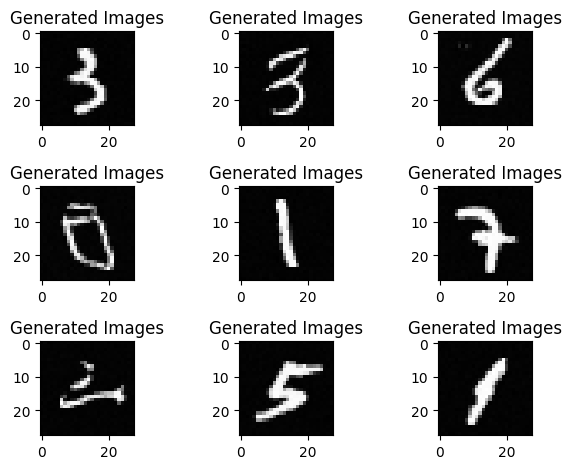

100%|██████████| 999/999 [00:07<00:00, 133.96it/s]


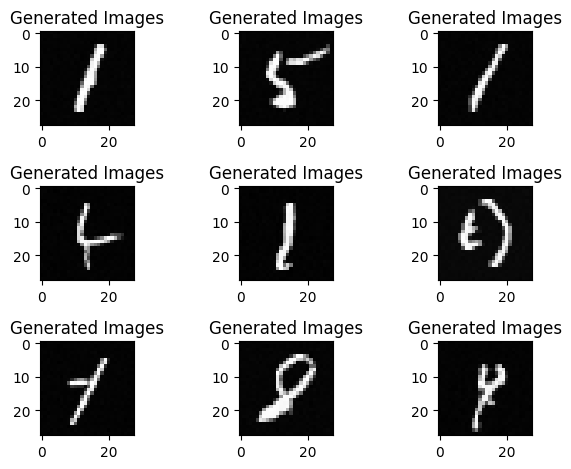

100%|██████████| 999/999 [00:07<00:00, 139.73it/s]


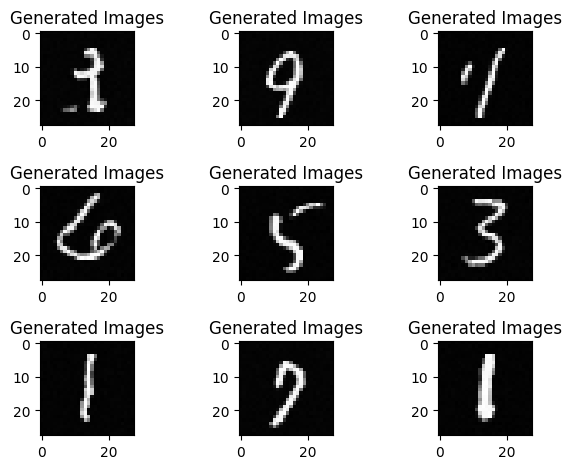

100%|██████████| 999/999 [00:06<00:00, 155.25it/s]


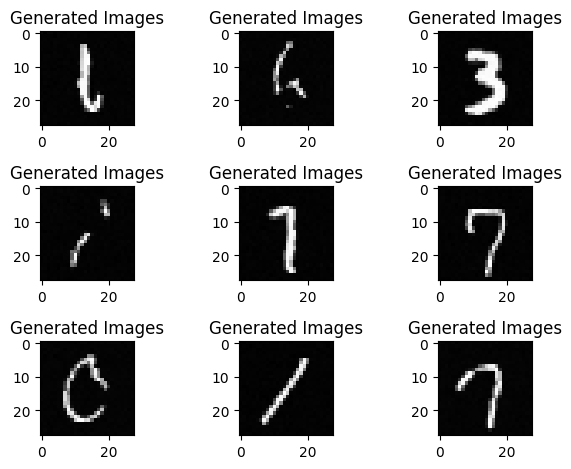

100%|██████████| 999/999 [00:07<00:00, 134.06it/s]


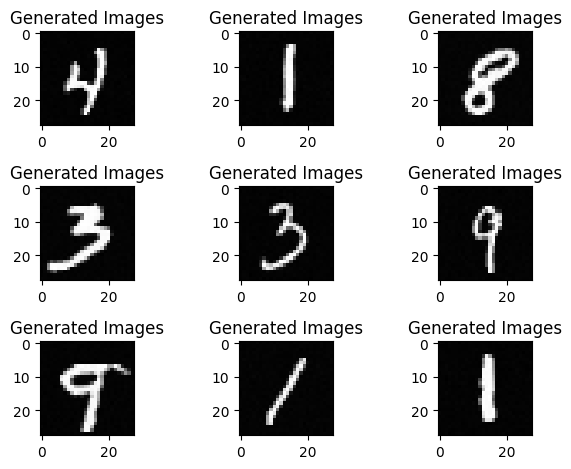

100%|██████████| 999/999 [00:07<00:00, 142.60it/s]


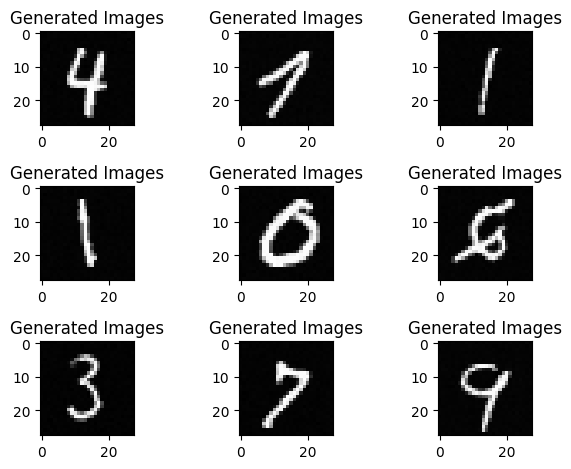

100%|██████████| 999/999 [00:06<00:00, 160.84it/s]


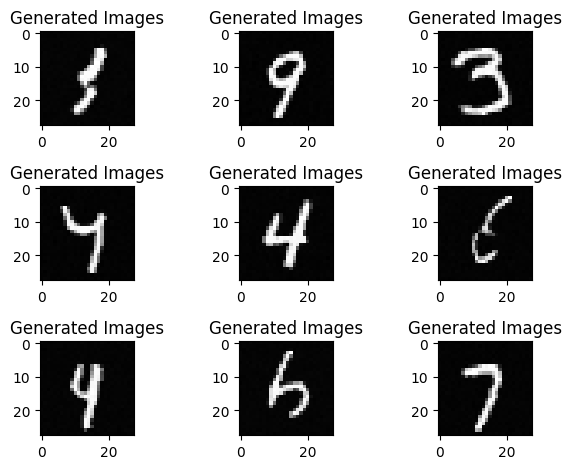

100%|██████████| 999/999 [00:07<00:00, 133.85it/s]


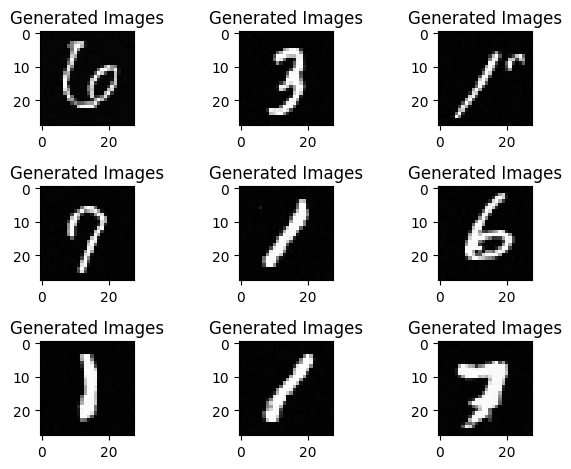

100%|██████████| 999/999 [00:04<00:00, 206.79it/s]


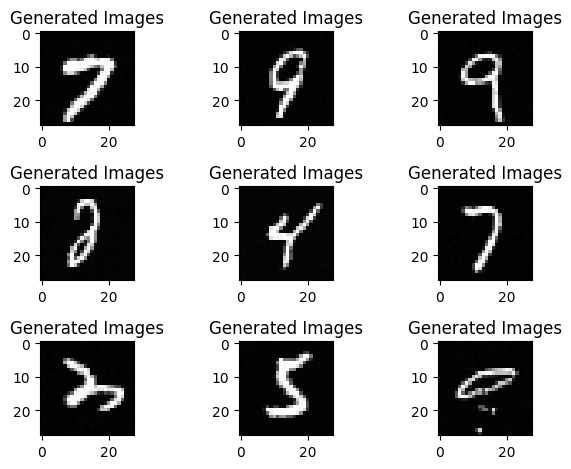

100%|██████████| 999/999 [00:04<00:00, 218.15it/s]


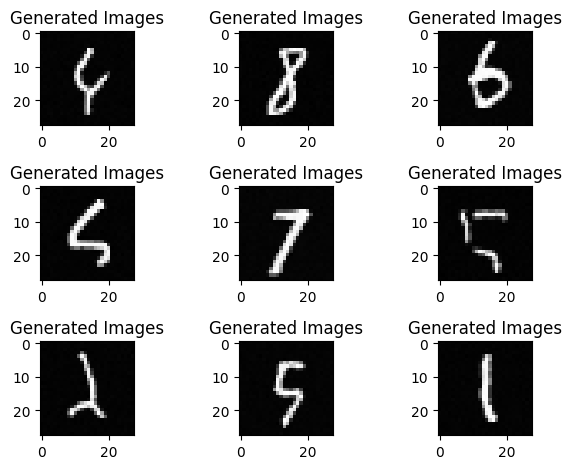

100%|██████████| 999/999 [00:04<00:00, 223.21it/s]


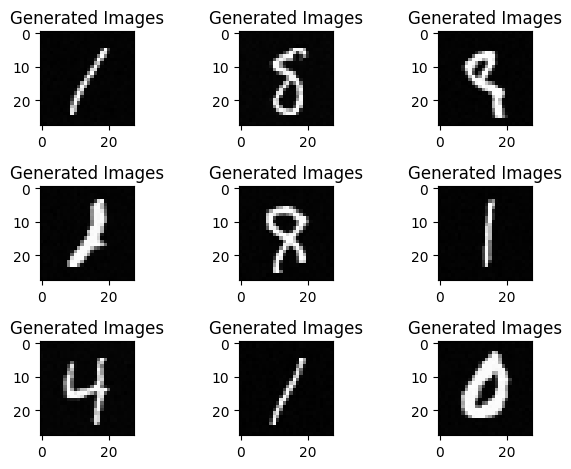

100%|██████████| 999/999 [00:04<00:00, 208.98it/s]


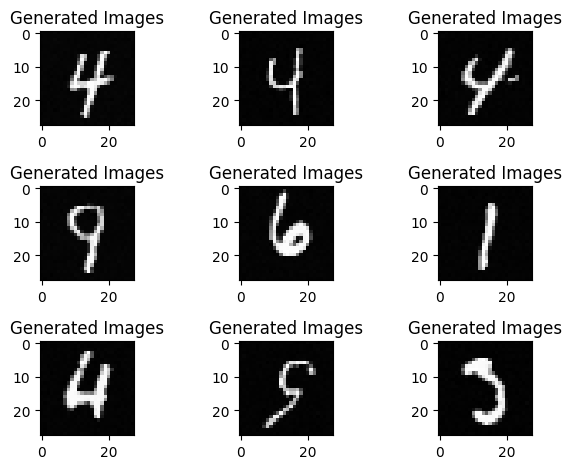

100%|██████████| 999/999 [00:05<00:00, 195.85it/s]


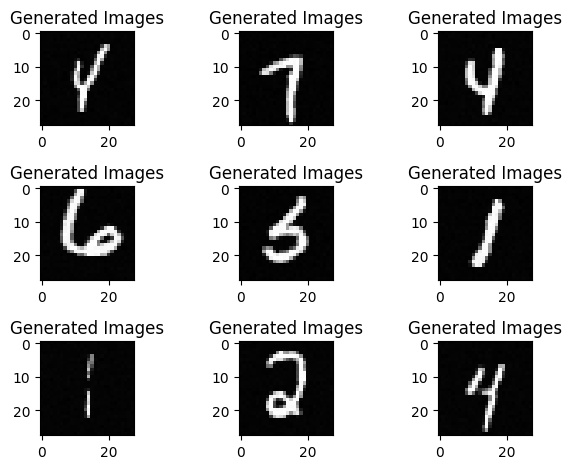

100%|██████████| 999/999 [00:04<00:00, 216.96it/s]


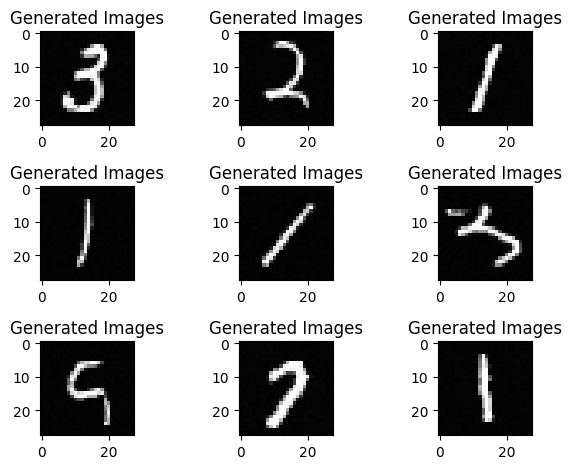

100%|██████████| 999/999 [00:04<00:00, 213.47it/s]


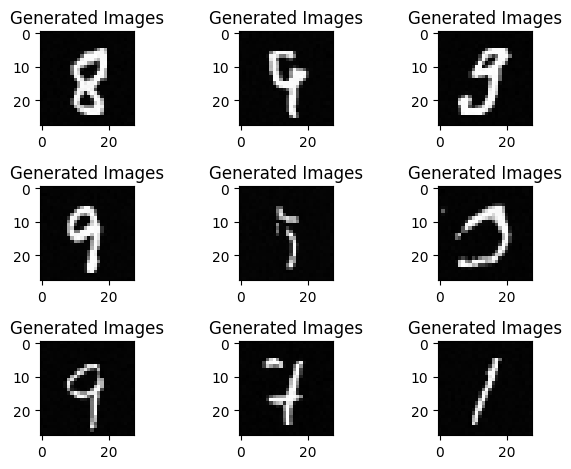

100%|██████████| 999/999 [00:04<00:00, 210.48it/s]


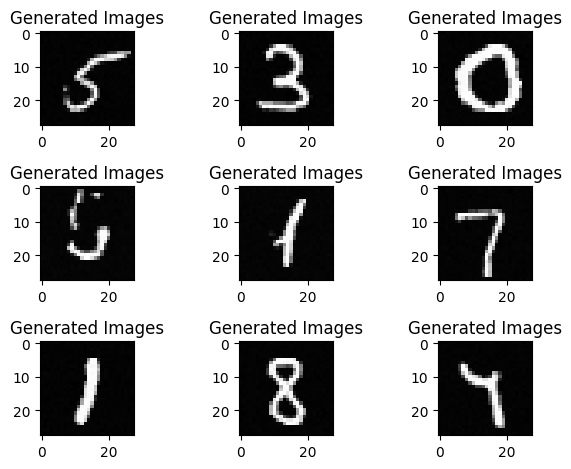

100%|██████████| 999/999 [00:04<00:00, 214.59it/s]


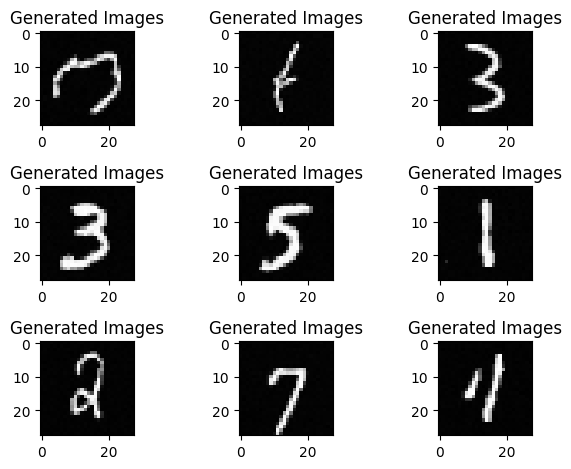

100%|██████████| 999/999 [00:04<00:00, 217.04it/s]


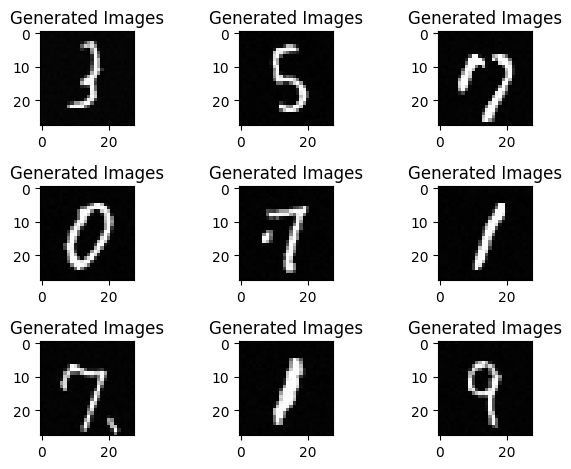

100%|██████████| 999/999 [00:04<00:00, 207.38it/s]


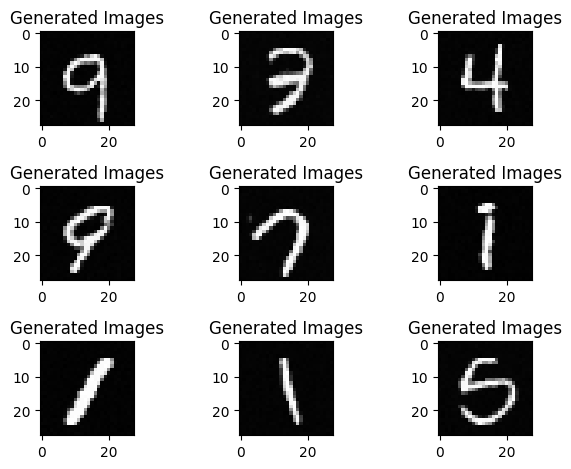

100%|██████████| 999/999 [00:05<00:00, 193.38it/s]


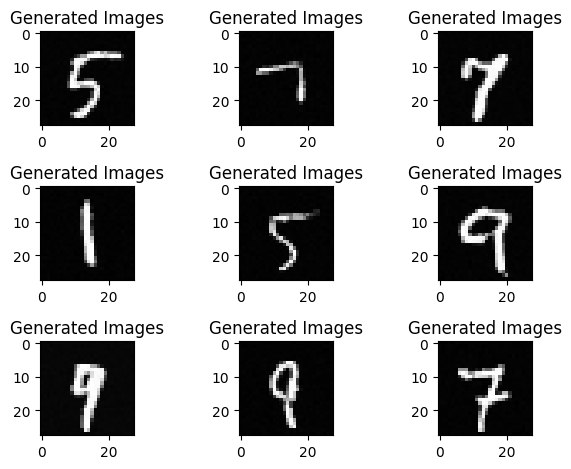

100%|██████████| 999/999 [00:04<00:00, 200.55it/s]


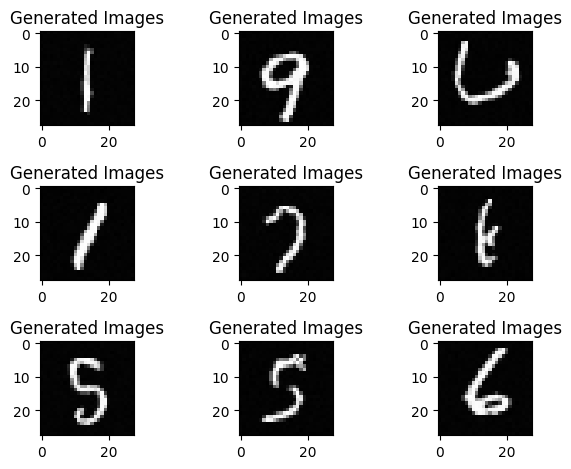

100%|██████████| 999/999 [00:04<00:00, 209.44it/s]


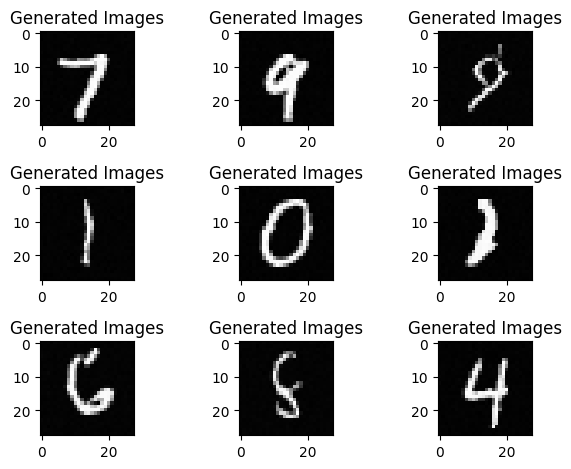

100%|██████████| 999/999 [00:04<00:00, 207.81it/s]


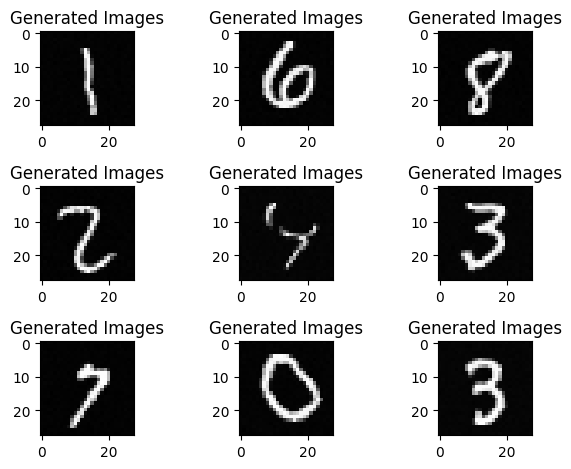

100%|██████████| 999/999 [00:04<00:00, 216.92it/s]


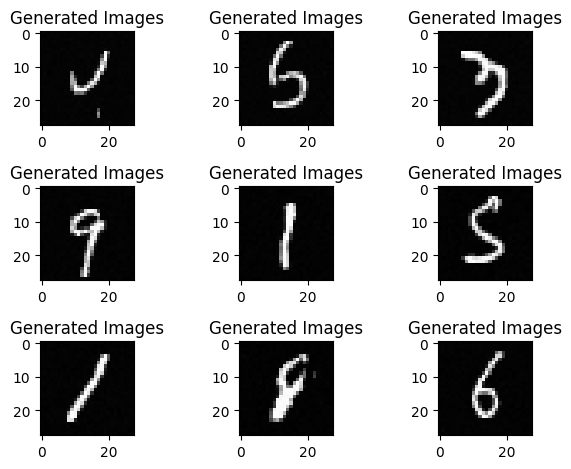

100%|██████████| 999/999 [00:04<00:00, 205.46it/s]


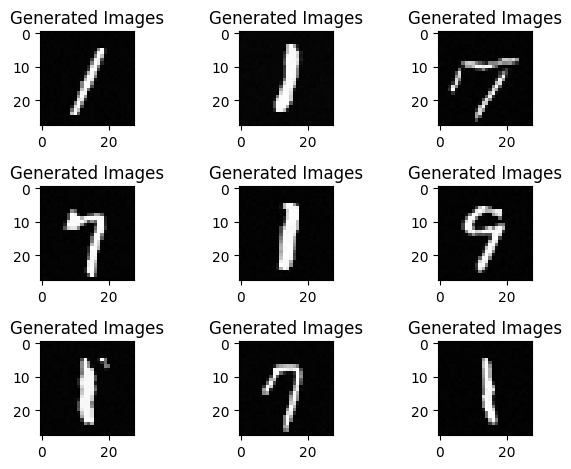

100%|██████████| 999/999 [00:04<00:00, 220.11it/s]


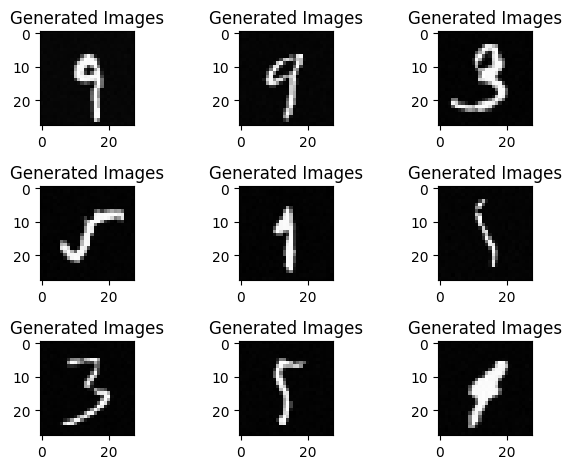

100%|██████████| 999/999 [00:04<00:00, 215.85it/s]


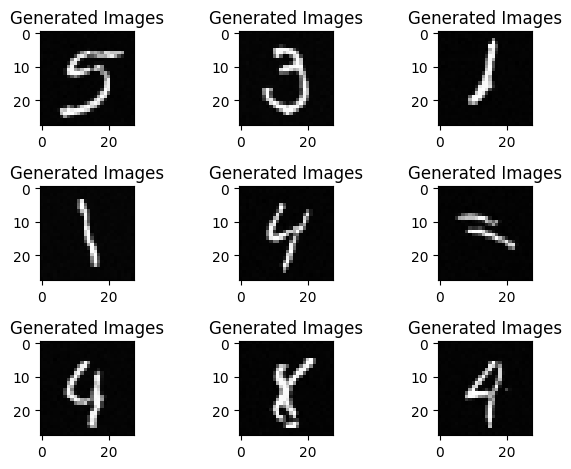

100%|██████████| 999/999 [00:04<00:00, 201.01it/s]


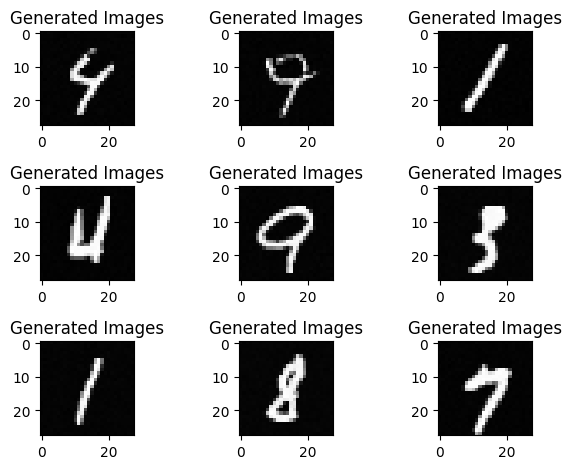

100%|██████████| 999/999 [00:04<00:00, 211.03it/s]


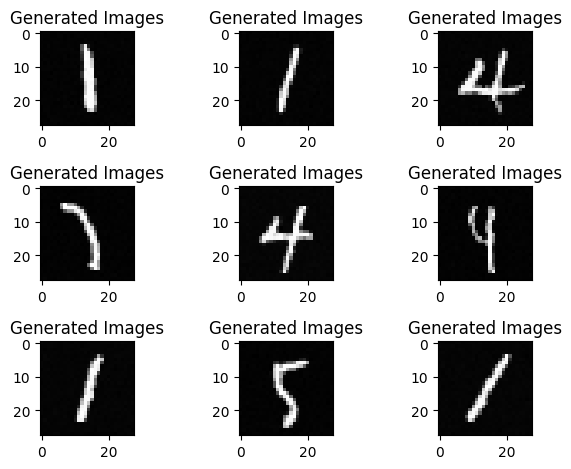

100%|██████████| 999/999 [00:05<00:00, 197.26it/s]


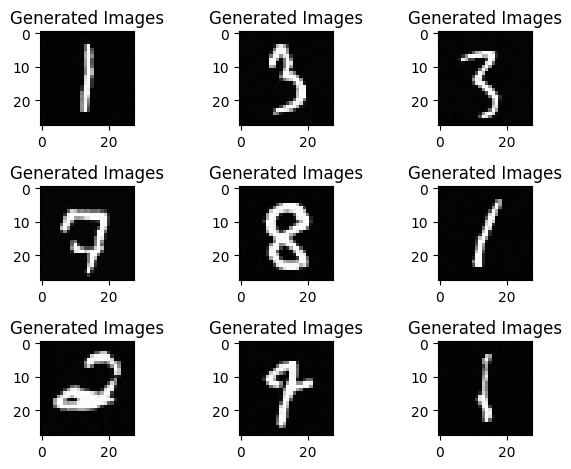

In [39]:
import matplotlib.pyplot as plt
import random
import numpy as np
import cv2

# Sampling
xt = torch.randn(batch_size, 1, 28, 28)

model.eval()
with torch.no_grad():
    for t in trange(999-1, -1, -1):
        time = torch.ones(batch_size) * t
        et = model(xt.to(device), time.to(device))  # predict noise
        xt = process.inverse(xt=xt, et=et, t=t)

labels = ["Generated Images"] * 9
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.tight_layout()
    plt.imshow(Tensor.cpu(xt[i][0]), cmap="gray", interpolation="none")
    plt.title(labels[i])

    res = xt[i][0].to("cpu")
    res = res.numpy().astype(np.float32) * 255
    ID = random.randint(1, 9999999)
    cv2.imwrite(f"./newData/m/{ID}.png", res)

plt.show()